### Imports

In [2]:
# Visualization
import matplotlib.pyplot as plt

# Data related libraries
import numpy as np
import pandas as pd

# Parameters handling libraries
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Neural Networks
import tensorflow as tf
from keras.utils import to_categorical

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print('GPU is available and will be used.')
else:
    print('GPU is not available. Falling back to CPU.')

GPU is not available. Falling back to CPU.


### Configuration

In [5]:
EXPERIMENT = "tara"
ACTIVITIES = ["relaxing", "eating", "walking", "studying"]

### Dataset

In [6]:
def check_missing_values(dataset: pd.DataFrame, dataset_identifier: str):
    # Check if there are any remaining missing values
    missing_values = dataset.isnull().sum().sum()
    if missing_values > 0:
        print(f"There are still {missing_values} missing values in the [{dataset_identifier}]")
    else:
        print(f"All missing values have been filled in the [{dataset_identifier}]")


In [7]:
def fill_missing_data(dataset: pd.DataFrame):
    # Forward fill
    dataset = dataset.fillna(method='ffill')  
    # backward fill missing values
    dataset = dataset.fillna(method='bfill')
    return dataset

In [8]:
source_directory = "final_datasets/all_features/"

# Loading `train` data
train_dataset = pd.read_csv(f"{source_directory}/{EXPERIMENT}_train_features.csv")
train_dataset.drop('time', axis=1, inplace=True) if 'time' in train_dataset.columns else None
check_missing_values(train_dataset, "train_dataset")
train_dataset = fill_missing_data(train_dataset)
check_missing_values(train_dataset, "train_dataset")
train_y = train_dataset[ACTIVITIES]
print("train_y", train_y.shape)
train_x = train_dataset.drop(ACTIVITIES, axis=1)
print("train_x", train_x.shape)

# Loading `validation` data
validation_dataset = pd.read_csv(f"{source_directory}/{EXPERIMENT}_validation.csv")
validation_dataset.drop('time', axis=1, inplace=True) if 'time' in validation_dataset.columns else None
check_missing_values(validation_dataset, "validation_dataset")
validation_dataset = fill_missing_data(validation_dataset)
check_missing_values(validation_dataset, "validation_dataset")
validation_y = validation_dataset[ACTIVITIES]
print("validation_y", validation_dataset.shape)
validation_x = validation_dataset.drop(ACTIVITIES, axis=1)
print("validation_x", validation_x.shape)

# Loading `test` data
test_dataset = pd.read_csv(f"{source_directory}/{EXPERIMENT}_test_features.csv")
test_dataset.drop('time', axis=1, inplace=True) if 'time' in test_dataset.columns else None
check_missing_values(test_dataset, "test_dataset")
test_dataset = fill_missing_data(test_dataset)
check_missing_values(test_dataset, "test_dataset")
test_y = test_dataset[ACTIVITIES]
print("test_y", test_y.shape)
test_x = test_dataset.drop(ACTIVITIES, axis=1)
print("test_x", test_x.shape)

There are still 8811 missing values in the [train_dataset]
All missing values have been filled in the [train_dataset]
train_y (20396, 4)
train_x (20396, 1056)
All missing values have been filled in the [validation_dataset]
All missing values have been filled in the [validation_dataset]
validation_y (1200, 1060)
validation_x (1200, 1056)
There are still 8811 missing values in the [test_dataset]
All missing values have been filled in the [test_dataset]
test_y (3545, 4)
test_x (3545, 1056)


In [10]:
def compute_grid_search_result(model_instance, parameters, X, y):
    grid_search_instance = GridSearchCV(model_instance, parameters)
    return grid_search_instance.fit(X, y)

def compute_metrics(test_y: np.ndarray, predicted_y: np.ndarray):
    accuracy_score = metrics.accuracy_score(test_y, predicted_y)
    precision_score = metrics.precision_score(test_y, predicted_y, average=None)
    recall_score = metrics.recall_score(test_y, predicted_y, average=None)
    f1_score = metrics.f1_score(test_y, predicted_y, average=None)
    roc_auc_score = metrics.roc_auc_score(test_y, predicted_y, average=None)
    
    return {
        "accuracy_score": accuracy_score,
        "precision_score": precision_score,
        "recall_score": recall_score,
        "f1_score": f1_score,
        "roc_auc_score": roc_auc_score,
    }

def add_new_key_value_to_dict(dict, key, value):
    dict[key] = value
    return dict

def fit_predict_and_compute_metrics(
        model_definition: type,
        parameters: dict,
        train_x: pd.DataFrame,
        train_y: pd.DataFrame,
        test_x: pd.DataFrame,
        test_y: pd.DataFrame
    ):

    model_instance: object = model_definition(**parameters)
    model_instance.fit(train_x, train_y)
    predicted_y: np.ndarray = model_instance.predict(test_x)
    metrics_result: dict = compute_metrics(test_y.values, predicted_y)
    return add_new_key_value_to_dict(metrics_result, "parameters", parameters)

In [11]:
def plot_results(results: dict, model_name: str):
    scores = {
        'Precision': results['precision_score'],
        'Recall': results['recall_score'],
        'F1-score': results['f1_score'],
        'Roc_auc_score': results['roc_auc_score']
    }

    _, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    opacity = 0.8

    for i, (score_name, score_values) in enumerate(scores.items()):
        x = np.arange(len(score_values))
        bar_offset = i * bar_width
        ax.bar(x + bar_offset, score_values, bar_width, alpha=opacity, label=score_name)

    ax.set_xlabel('Activity')
    ax.set_ylabel('Score')
    ax.set_title(f'{model_name} Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(ACTIVITIES)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    for activity, score_values in zip(ACTIVITIES, zip(*scores.values())):
        print(f'{activity}: {dict(zip(scores.keys(), score_values))}')

## LSTM

### Prepare data

In [12]:
def reshape_examples(data: np.array) -> np.array:
    return np.reshape(data, (data.shape[0], data.shape[1], 1))

# -------- TRAIN -------- #
train_x: np.array = train_x.to_numpy()
train_y: np.array = train_y.to_numpy()
train_x_reshaped = reshape_examples(train_x)

print("train_x.shape", train_x.shape)
print("train_y.shape", train_y.shape)
print("train_x_reshaped.shape", train_x_reshaped.shape)

# -------- VALIDATION -------- #
validation_x: np.array = validation_x.to_numpy()
validation_y: np.array = validation_y.to_numpy()
validation_x_reshaped = reshape_examples(validation_x)

print("validation_x.shape", validation_x.shape)
print("validation_y.shape", validation_y.shape)
print("validation_x_reshaped.shape", validation_x_reshaped.shape)

# -------- TEST -------- #
test_x: np.array = test_x.to_numpy()
test_y: np.array = test_y.to_numpy()
test_x_reshaped = reshape_examples(test_x)

print("test_x.shape", test_x.shape)
print("test_y.shape", test_y.shape)
print("test_x_reshaped.shape", test_x_reshaped.shape)

input_shape = (train_x_reshaped.shape[1], 1)
output_shape = train_y.shape[1]
print("input_shape", input_shape)
print("output_shape", output_shape)

train_x.shape (20396, 1056)
train_y.shape (20396, 4)
train_x_reshaped.shape (20396, 1056, 1)
validation_x.shape (1200, 1056)
validation_y.shape (1200, 4)
validation_x_reshaped.shape (1200, 1056, 1)
test_x.shape (3545, 1056)
test_y.shape (3545, 4)
test_x_reshaped.shape (3545, 1056, 1)
input_shape (1056, 1)
output_shape 4


### Train 

In [13]:
def build_lstm_model(input_shape, output_shape, units, dropout):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(units, input_shape=input_shape))
    model.add(tf.keras.layers.Dropout(dropout))
    
    model.add(tf.keras.layers.Dense(units, activation='relu'))
    
    model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
        ]
    )

    return model

def run_lstm_experiment(
        train_x, train_y, validation_x, validation_y, test_x, test_y,
        input_shape, output_shape,
        units=1000, dropout= 0.5, epochs=10, batch_size=64
    ):
    model = build_lstm_model(input_shape, output_shape, units, dropout)
    model.summary()
    history = model.fit(
        train_x, train_y,
        epochs=epochs, batch_size=batch_size,
        validation_data=(validation_x, validation_y)
    )   
    print(history.history)

    # Plotting the training loss and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plotting the training accuracy and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


    predicted_y = to_categorical(np.argmax(model.predict(test_x), axis=1))
    lstm_result: dict = compute_metrics(test_y, predicted_y)
    plot_results(lstm_result, "LSTM")
    

2023-06-25 13:37:49.669878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 500)               1004000   
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 500)               250500    
                                                                 
 dense_1 (Dense)             (None, 4)                 2004      
                                                                 
Total params: 1,256,504
Trainable params: 1,256,504
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
319/319 [==============================] - 1664s 5s/step - loss: 1.1193 - accuracy: 0.4282 - precision: 0.4184 - recall: 0.0875 - val_loss: 1.8089 - val_accuracy: 0.25

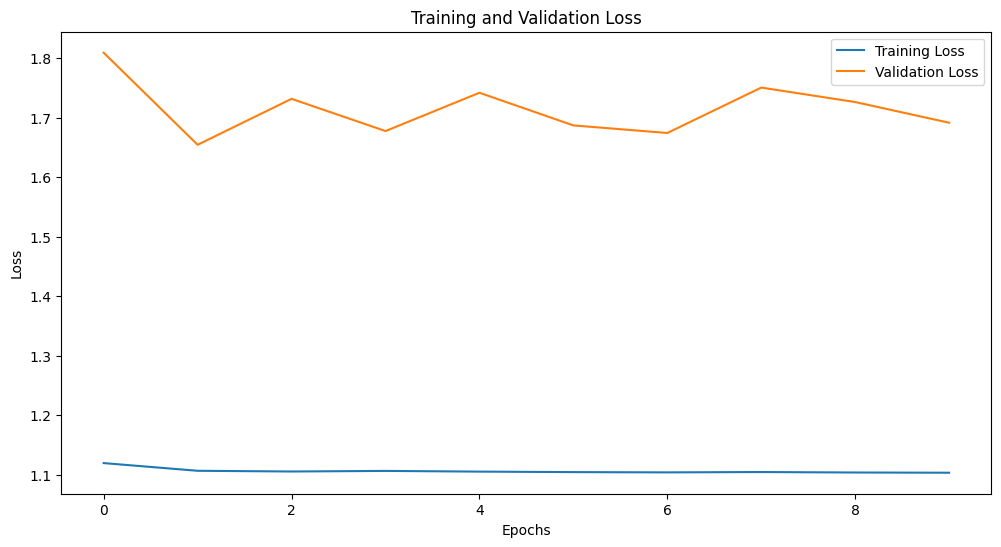

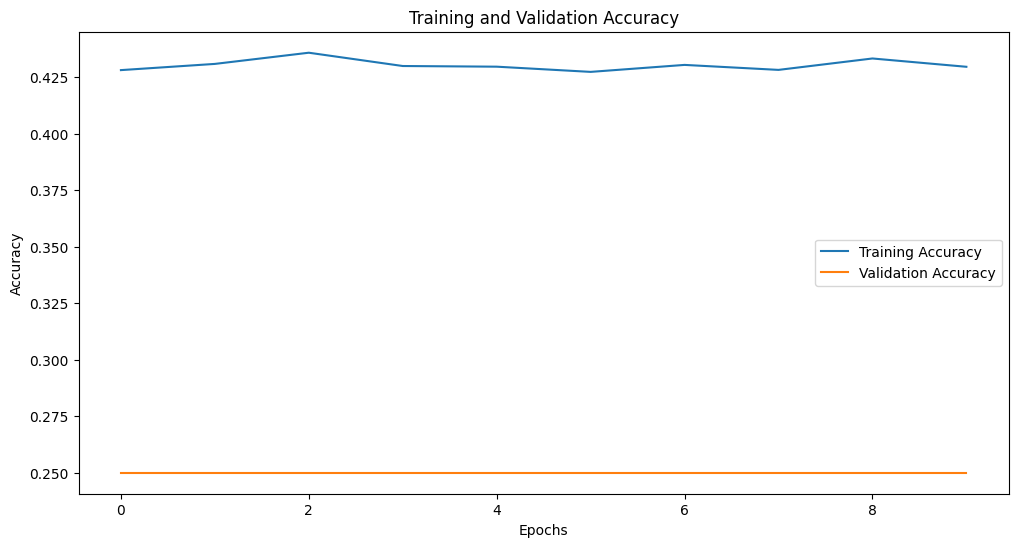

111/111 [==============================] - 140s 1s/step


/home/samanu/miniconda3/envs/ml4qs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


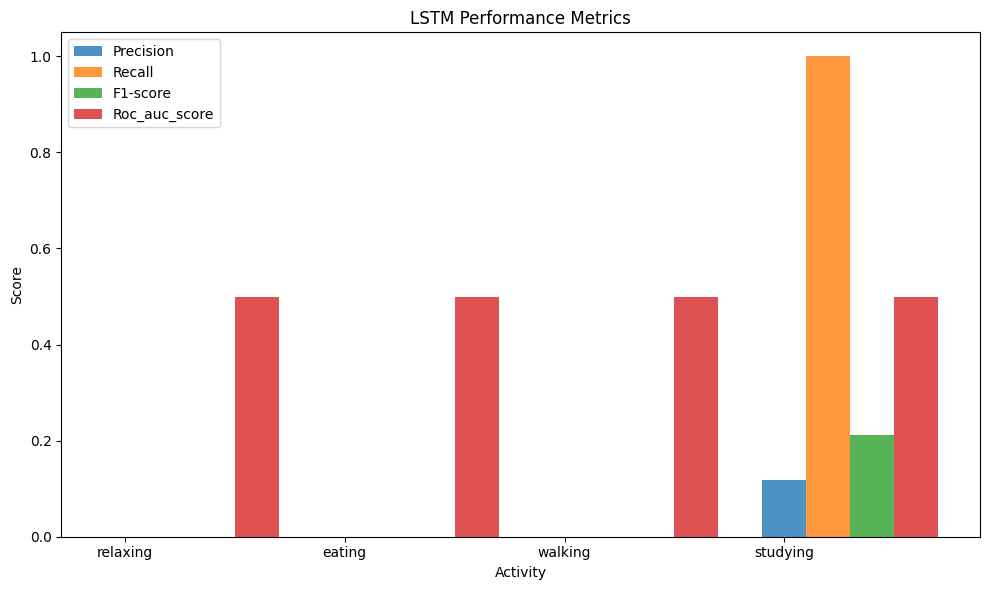

relaxing: {'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0, 'Roc_auc_score': 0.5}
eating: {'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0, 'Roc_auc_score': 0.5}
walking: {'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0, 'Roc_auc_score': 0.5}
studying: {'Precision': 0.11819464033850494, 'Recall': 1.0, 'F1-score': 0.2114026236125126, 'Roc_auc_score': 0.5}


In [14]:
run_lstm_experiment(
    train_x_reshaped, train_y, validation_x_reshaped, validation_y, test_x_reshaped, test_y,
    input_shape, output_shape,
    units=500, dropout= 0.5, epochs=10, batch_size=64
)